In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch  # Go to readme for torch installation instructions
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import pickle
import os

c:\Users\S.SHIKHAR\Desktop\BERT\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Step 1: Load dataset ===
file_path = "random_augmented_balanced_dataset.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

In [3]:
# === Step 2: Clean text column ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

df['text'] = df['text'].apply(clean_text)

In [4]:
# === Step 3: Encode intent to numeric label ===
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# Show class mapping (for your reference)
print("Label mapping (label -> intent):")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

Label mapping (label -> intent):
0: applicable disease
1: ask more
2: cause
3: definition
4: disease manifestations
5: method
6: symptoms
7: treatment
8: treatment method
9: usage


In [5]:
# === Step 4: Train/Val/Test Split ===
# Use 80% Train, 10% Val, 10% Test
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

In [6]:
# # Use this for 70% train, 20% val, 10% test
# train_texts, temp_texts, train_labels, temp_labels = train_test_split(
#     df['text'].tolist(),
#     df['label_id'].tolist(),
#     test_size=0.3,
#     stratify=df['label_id'],
#     random_state=42
# )

# val_texts, test_texts, val_labels, test_labels = train_test_split(
#     temp_texts,
#     temp_labels,
#     test_size=1/3,  # 10% of total = 1/3 of 30%
#     stratify=temp_labels,
#     random_state=42
# )


In [7]:
# === Step 5: Save label encoder ===
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
    
print("\nSaved label encoder as 'label_encoder.pkl'.")


Saved label encoder as 'label_encoder.pkl'.


In [8]:
# === Step 6: Save split datasets with text, intent, and label ===
os.makedirs("splits", exist_ok=True)

train_df[['text', 'intent', 'label']].to_csv("splits/train.csv", index=False)
val_df[['text', 'intent', 'label']].to_csv("splits/val.csv", index=False)
test_df[['text', 'intent', 'label']].to_csv("splits/test.csv", index=False)

print("✅ Saved split CSVs with text, intent, and label to 'splits/' folder.")

✅ Saved split CSVs with text, intent, and label to 'splits/' folder.


In [9]:
import torch
print(torch.cuda.is_available())  # Should return True


True


In [10]:
# === Step 1: Load label encoder ===
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

In [11]:
# === Step 2: Load datasets ===
train_df = pd.read_csv("splits/train.csv")
val_df = pd.read_csv("splits/val.csv")
test_df = pd.read_csv("splits/test.csv")

In [12]:
# === Step 3: Load BERT tokenizer ===
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# === Step 3.5: Compute class weights ===
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Boost underperforming classes
boost_labels = ["treatment", "treatment method", "symptoms", "disease manifestations"]
boost_indices = label_encoder.transform(boost_labels)

for idx in boost_indices:
    class_weights_tensor[idx] *= 1.0  # You can adjust the factor

In [15]:
# === Step 4: Define PyTorch Dataset ===
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=192):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [16]:
# === Step 5: Create Dataset instances ===
train_dataset = IntentDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset   = IntentDataset(val_df["text"].tolist(), val_df["label"].tolist(), tokenizer)
test_dataset  = IntentDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)


In [17]:
# === Step 6: Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

print("✅ Tokenization and DataLoaders are ready!")

✅ Tokenization and DataLoaders are ready!


In [18]:
# === Step 1: Define the model ===
class BERTClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.15):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        x = self.dropout(cls_output)
        return self.classifier(x)

In [19]:
# === Step 2: Train and eval loops ===
def train_epoch(model, dataloader, loss_fn, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

def eval_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

In [20]:
# === Step 4: Setup ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes).to(device)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
# === Setup Scheduler Parameters ===
num_epochs = 10  # total number of epochs you are planning to train
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)  # 10% of total steps

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


In [21]:
# === Step 5: Training Loop ===
best_val_acc = 0
patience = 2
patience_counter = 0

# Lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(40):
    print(f"\n🌟 Epoch {epoch + 1}")

    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, scheduler, device)
    val_loss, val_acc = eval_epoch(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


print("🎯 Training complete.")


🌟 Epoch 1


Validating: 100%|██████████| 95/95 [00:04<00:00, 20.43it/s]


Train Loss: 1.7033 | Train Acc: 0.3825
Val   Loss: 1.3413 | Val   Acc: 0.5302
✅ Saved best model.

🌟 Epoch 2


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.98it/s]


Train Loss: 1.0819 | Train Acc: 0.6110
Val   Loss: 1.0474 | Val   Acc: 0.6311
✅ Saved best model.

🌟 Epoch 3


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.65it/s]


Train Loss: 0.6551 | Train Acc: 0.7733
Val   Loss: 0.8866 | Val   Acc: 0.7233
✅ Saved best model.

🌟 Epoch 4


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.48it/s]


Train Loss: 0.3619 | Train Acc: 0.8855
Val   Loss: 0.9452 | Val   Acc: 0.7266
✅ Saved best model.

🌟 Epoch 5


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.64it/s]


Train Loss: 0.2270 | Train Acc: 0.9289
Val   Loss: 0.9832 | Val   Acc: 0.7697
✅ Saved best model.

🌟 Epoch 6


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.79it/s]


Train Loss: 0.1391 | Train Acc: 0.9575
Val   Loss: 1.0465 | Val   Acc: 0.7724
✅ Saved best model.

🌟 Epoch 7


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.77it/s]


Train Loss: 0.0936 | Train Acc: 0.9726
Val   Loss: 1.1183 | Val   Acc: 0.7916
✅ Saved best model.

🌟 Epoch 8


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.35it/s]


Train Loss: 0.0651 | Train Acc: 0.9811
Val   Loss: 1.1459 | Val   Acc: 0.7983
✅ Saved best model.

🌟 Epoch 9


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.99it/s]


Train Loss: 0.0502 | Train Acc: 0.9855
Val   Loss: 1.1317 | Val   Acc: 0.8009
✅ Saved best model.

🌟 Epoch 10


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.79it/s]


Train Loss: 0.0390 | Train Acc: 0.9880
Val   Loss: 1.1507 | Val   Acc: 0.7989

🌟 Epoch 11


Validating: 100%|██████████| 95/95 [00:04<00:00, 19.69it/s]

Train Loss: 0.0315 | Train Acc: 0.9902
Val   Loss: 1.1507 | Val   Acc: 0.7989
⛔ Early stopping triggered.
🎯 Training complete.


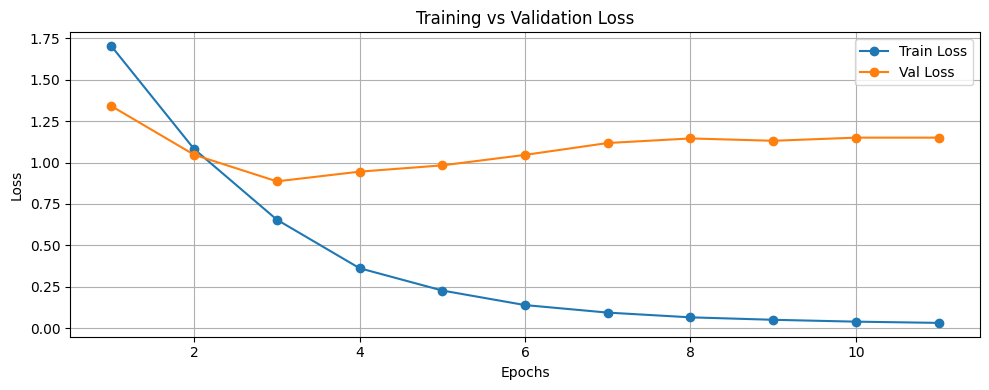

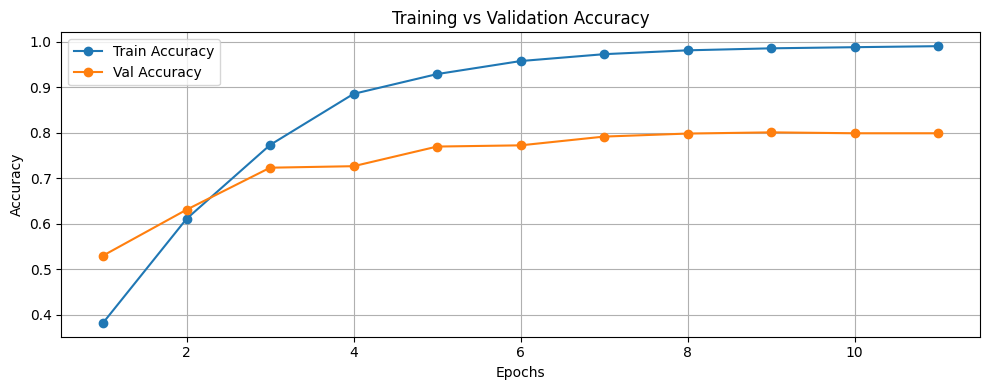

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_curve.png")
plt.show()


In [23]:
# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
model = BERTClassifier(num_classes)
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()

C:\Users\S.SHIKHAR\AppData\Local\Temp\ipykernel_24284\66550894.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [24]:
# === Predict on Test Set ===
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [25]:
# === Convert predictions and labels to strings (optional) ===
true_labels = label_encoder.inverse_transform(all_labels)
pred_labels = label_encoder.inverse_transform(all_preds)

In [26]:
# === 1. Final Test Accuracy ===
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Final Test Accuracy: {accuracy:.4f}")

# === 2. Classification Report ===
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels, digits=4))


✅ Final Test Accuracy: 0.8011

📊 Classification Report:
                        precision    recall  f1-score   support

    applicable disease     0.9029    0.9240    0.9133       171
              ask more     0.8867    0.8693    0.8779       153
                 cause     0.7266    0.7426    0.7345       136
            definition     0.8919    0.8354    0.8627       158
disease manifestations     0.6714    0.6861    0.6787       137
                method     0.8864    0.7500    0.8125       156
              symptoms     0.7541    0.7023    0.7273       131
             treatment     0.6467    0.7200    0.6814       150
      treatment method     0.7049    0.8217    0.7588       157
                 usage     0.9474    0.9057    0.9260       159

              accuracy                         0.8011      1508
             macro avg     0.8019    0.7957    0.7973      1508
          weighted avg     0.8071    0.8011    0.8026      1508



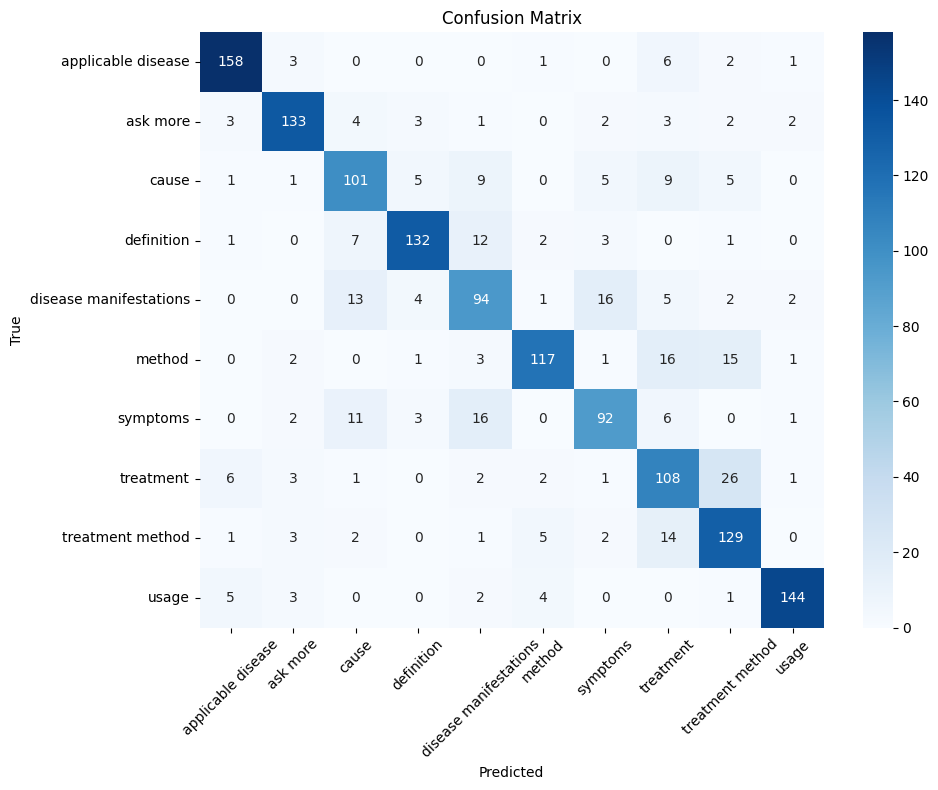

In [27]:
# === 3. Confusion Matrix ===
cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()